In [38]:
# MGMT58600 - Armand Debray and Harkanwar Chadha
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind #use scipy for stats 

# Load the dataset
file_path = "C:\\Users\\harka\\Downloads\\archive (9)\\matches.csv" #we chose a dataset centered around Premier League match statistics
data = pd.read_csv(file_path) #our primary intent is to analyze the statistics and provide insights that could be useful for a sports gambling app 

# Step 1 -- BEGIN DATA CLEANING
#Remove the 'attendance' and 'notes' columns -- these columns were dead and empty (had no values off of Kaggle)
data_cleaned = data.drop(columns=['attendance', 'notes'])

# Fill the missing values in the 'dist' column using the median value
median_dist = data_cleaned['dist'].median()
data_cleaned['dist'].fillna(median_dist, inplace=True)

# Display the first few rows of the cleaned dataset to check for insights 
print(data_cleaned.head())


   Unnamed: 0        date           time            comp        round  day  \
0           0  2020-09-21  20:15 (21:15)  Premier League  Matchweek 2  Mon   
1           2  2020-09-27  16:30 (17:30)  Premier League  Matchweek 3  Sun   
2           4  2020-10-03  17:30 (18:30)  Premier League  Matchweek 4  Sat   
3           5  2020-10-17  17:30 (18:30)  Premier League  Matchweek 5  Sat   
4           7  2020-10-24  12:30 (13:30)  Premier League  Matchweek 6  Sat   

  venue result  gf  ga  ...         referee  match report  sh  sot  dist fk  \
0  Away      W   3   1  ...  Andre Marriner  Match Report  13    8  21.1  2   
1  Home      L   2   5  ...  Michael Oliver  Match Report  16    5  19.8  1   
2  Away      D   1   1  ...       Mike Dean  Match Report  23    1  18.2  1   
3  Home      W   1   0  ...  Chris Kavanagh  Match Report  13    5  17.7  0   
4  Away      D   1   1  ...  Anthony Taylor  Match Report  14    7  20.9  1   

  pk pkatt  season             team  
0  1     1    2024

In [2]:
#Relevant stats, gf: 'goals for' team, 'goals against' team, 'poss' is possession, 'sh' is total shots, 'sot' is shots on target
data_cleaned[['gf', 'ga', 'poss', 'sh', 'sot']].describe()

,gf,ga,poss,sh,sot
count,4788.000000,4788.000000,4788.000000,4788.000000,4788.000000
mean,1.447995,1.405388,50.432957,12.619256,4.261278
std,1.312635,1.286927,12.810958,5.548444,2.459963
min,0.000000,0.000000,18.000000,0.000000,0.000000
25%,0.000000,0.000000,41.000000,9.000000,2.000000
50%,1.000000,1.000000,51.000000,12.000000,4.000000
75%,2.000000,2.000000,60.000000,16.000000,6.000000
max,9.000000,9.000000,82.000000,36.000000,15.000000


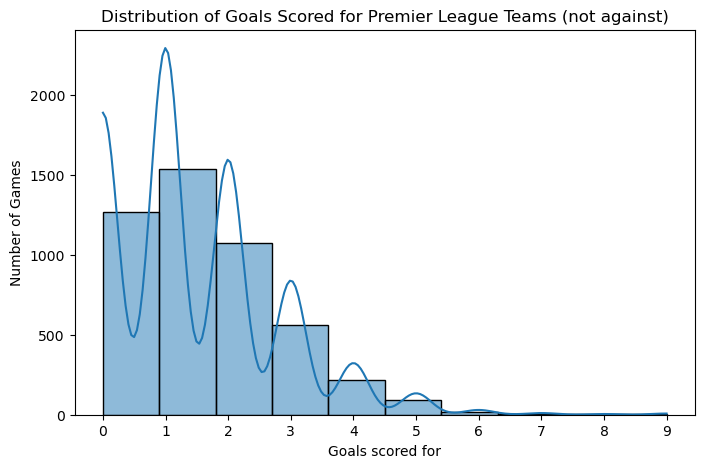

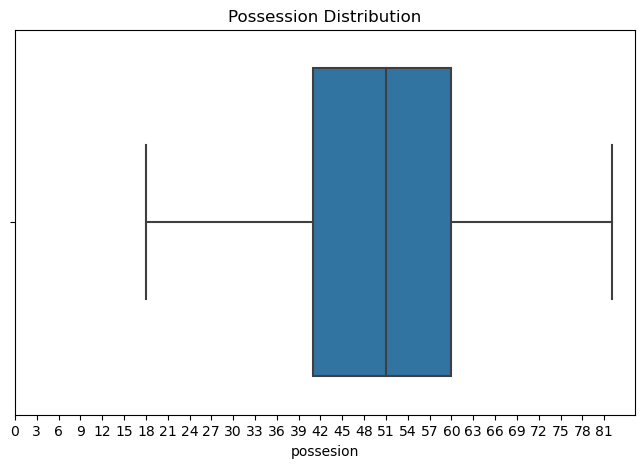

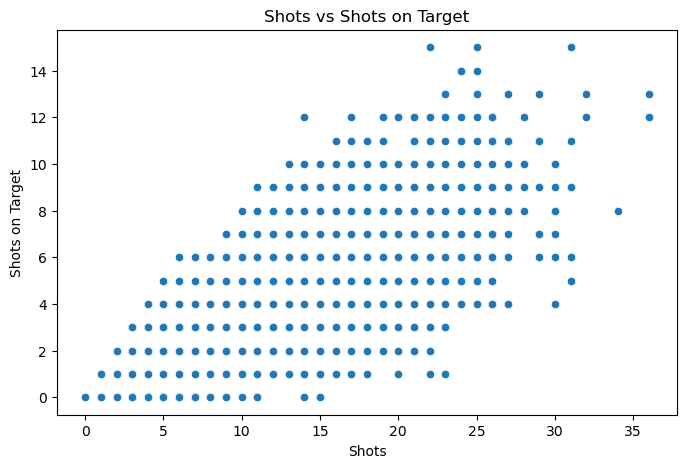

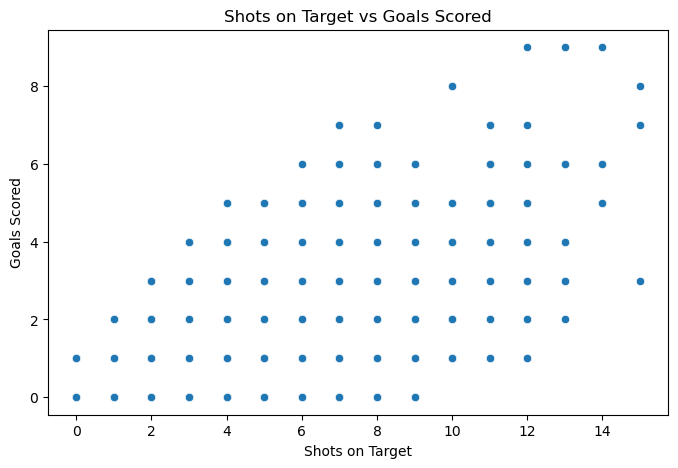

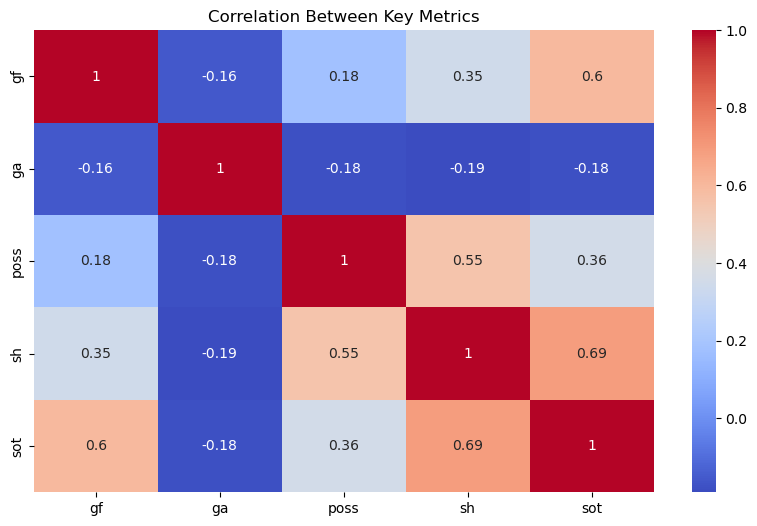

In [42]:
# Step 2 -- BEGIN DATA VISUALIZATION  
# Histogram for goals scored 
plt.figure(figsize=(8,5))
sns.histplot(data_cleaned['gf'], bins=10, kde=True)
plt.title('Distribution of Goals Scored for Premier League Teams (not against)')
plt.ylabel('Number of Games')
plt.xlabel('Goals scored for')
plt.xticks(ticks=range(0, int(data_cleaned['gf'].max()) + 1)) #setting xticks to show goals scored for the team 
plt.show()

# Box plot for possession (averaging around 52%)
plt.figure(figsize=(8,5))
sns.boxplot(data=data_cleaned, x='poss')
plt.xticks(ticks=range(0, int(data_cleaned['poss'].max()) + 1,3)) #intervals of 3 for more accurate reading
plt.xlabel('Possesion')
plt.title('Possession Distribution')
plt.show()

# Scatter plot for shots vs shots on target
plt.figure(figsize=(8,5))
sns.scatterplot(data=data_cleaned, x='sh', y='sot')
plt.title('Shots vs Shots on Target')
plt.xlabel('Shots')
plt.ylabel('Shots on Target')
plt.show()

# Scatter plot to visualize the relationship between shots on target and goals scored
plt.figure(figsize=(8,5))
sns.scatterplot(data=data_cleaned, x='sot', y='gf')
plt.title('Shots on Target vs Goals Scored')
plt.xlabel('Shots on Target')
plt.ylabel('Goals Scored')
plt.show()

# Heatmap of correlation, shots on target and shots are generally positively correlated (CORRELATION ANALYSIS) 
# shots and possesion are also pretty positively correlated
# Shots and shots on target are positively correlated with goals, with shots on target having a stronger positive correlation than total shots.
# Finally, it makes sense that shots on target and shots for the team do not positively correlate with goals against the team 
plt.figure(figsize=(10,6))
corr_matrix = data_cleaned[['gf', 'ga', 'poss', 'sh', 'sot']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Key Metrics')
plt.show()

In [4]:
# Correlation matrix, displays same values as the heatmap above without the fancy color scheme 
data_cleaned[['gf', 'ga', 'poss', 'sh', 'sot']].corr()


,gf,ga,poss,sh,sot
gf,1.000000,-0.155266,0.179932,0.348860,0.595544
ga,-0.155266,1.000000,-0.177737,-0.190601,-0.176655
poss,0.179932,-0.177737,1.000000,0.553565,0.357195
sh,0.348860,-0.190601,0.553565,1.000000,0.689669
sot,0.595544,-0.176655,0.357195,0.689669,1.000000


In [5]:
# Step 3 -- BEGIN EXPLORATORY DATA ANALYSIS

# Splitting data into teams with high possession and low possession:
# The condition 'data_cleaned['poss'] > data_cleaned['poss'].median()' filters the dataset for teams with possession above the median, assigning their goals scored ('gf') to 'high_poss'.
high_poss = data_cleaned[data_cleaned['poss'] > data_cleaned['poss'].median()]['gf']

# Similarly, this condition filters teams with possession less than or equal to the median, assigning their goals scored ('gf') to 'low_poss'.
low_poss = data_cleaned[data_cleaned['poss'] <= data_cleaned['poss'].median()]['gf']

# Conducting an independent t-test to compare the means of the goals scored ('gf') between teams with high possession and low possession:
# The t-test checks if the difference in means is statistically significant (whether teams with higher possession score significantly more goals than those with lower possession).
t_stat, p_value = ttest_ind(high_poss, low_poss)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

#Teams with higher possession (above the median) score significantly more goals than teams with lower possession (below or equal to the median). 
#The results are strong enough that you can confidently say that possession has a meaningful positive impact on goals scored.

T-statistic: 9.887543615467534, P-value: 7.79334709319742e-23


In [6]:
# Split data into winning and losing teams (draws excluded)
winning_teams = data_cleaned[data_cleaned['gf'] > data_cleaned['ga']]['poss'] #goals for team greater than goals against
losing_teams = data_cleaned[data_cleaned['gf'] < data_cleaned['ga']]['poss'] #opposite of above 

# Conduct a t-test
t_stat, p_value = ttest_ind(winning_teams, losing_teams)

# Output the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in possession between winning and losing teams.")
else:
    print("There is no statistically significant difference in possession between winning and losing teams.")


T-statistic: 10.440319579844832, P-value: 3.6078066966662884e-25
There is a statistically significant difference in possession between winning and losing teams.


In [39]:
# Define weekend and weekday matches (Time Based Analysis)
weekend_matches = data_cleaned[data_cleaned['day'].isin(['Sat', 'Sun'])]['gf']
weekday_matches = data_cleaned[~data_cleaned['day'].isin(['Sat', 'Sun'])]['gf']

# Conduct a t-test
t_stat, p_value = ttest_ind(weekend_matches, weekday_matches)

# Output the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in goals scored between weekend and weekday matches.")
else:
    print("There is no statistically significant difference in goals scored between weekend and weekday matches.")

T-statistic: 1.6134684367364092, P-value: 0.10670870168128836
There is no statistically significant difference in goals scored between weekend and weekday matches.


In [34]:
# Group the data by 'round' and calculate the mean of numeric metrics
# We use `as_index=True` to keep 'round' as an index and reset it afterward
numeric_cols = data_cleaned.select_dtypes(include=['number'])
grouped_data_by_round = numeric_cols.groupby(data_cleaned['round']).mean().reset_index()

# Display the grouped data for goals scored and shots
print(grouped_data_by_round[['round', 'gf', 'ga', 'sh', 'sot']].head(20))  # Adjust the number of rows to see more results
#strings are unordered numerically so this is not great, for the graphs we extract the number to order the matchweeks 

           round        gf        ga         sh       sot
0    Matchweek 1  1.468254  1.388889  12.650794  4.023810
1   Matchweek 10  1.619048  1.492063  12.682540  4.523810
2   Matchweek 11  1.301587  1.269841  12.198413  3.865079
3   Matchweek 12  1.333333  1.285714  12.960317  4.674603
4   Matchweek 13  1.460317  1.428571  12.849206  4.555556
5   Matchweek 14  1.603175  1.587302  12.920635  4.531746
6   Matchweek 15  1.484127  1.412698  11.904762  4.230159
7   Matchweek 16  1.317460  1.246032  11.976190  4.079365
8   Matchweek 17  1.420635  1.380952  12.896825  4.531746
9   Matchweek 18  1.134921  1.134921  11.492063  4.000000
10  Matchweek 19  1.515873  1.507937  12.428571  3.865079
11   Matchweek 2  1.626984  1.619048  12.658730  4.023810
12  Matchweek 20  1.420635  1.365079  12.428571  4.198413
13  Matchweek 21  1.214286  1.190476  12.373016  4.238095
14  Matchweek 22  1.531746  1.444444  12.317460  4.333333
15  Matchweek 23  1.341270  1.357143  12.238095  3.960317
16  Matchweek 

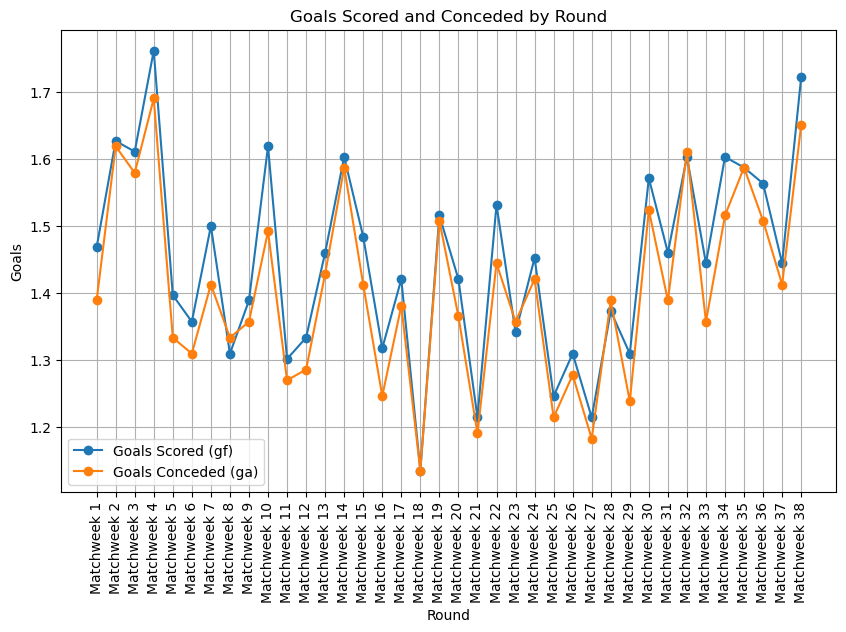

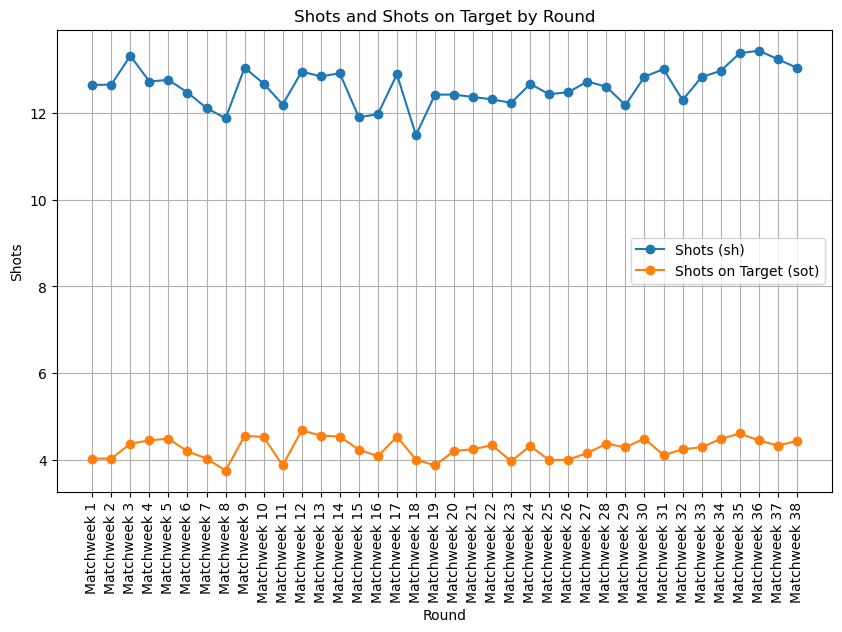

In [37]:
# Create a new column 'matchweek_num' by extracting the numeric part from 'round' -- so graphs follow a more natural flow 
grouped_data_by_round['matchweek_num'] = grouped_data_by_round['round'].str.extract('(\d+)').astype(int)

# Sort the data by 'matchweek_num'
grouped_data_by_round = grouped_data_by_round.sort_values('matchweek_num')

# Plot goals scored and conceded by matchweek (Time Series Analysis Part 2 hehe)
plt.figure(figsize=(10,6))
plt.plot(grouped_data_by_round['round'], grouped_data_by_round['gf'], label='Goals Scored (gf)', marker='o')
plt.plot(grouped_data_by_round['round'], grouped_data_by_round['ga'], label='Goals Conceded (ga)', marker='o')
plt.title('Goals Scored and Conceded by Round')
plt.xlabel('Round')
plt.ylabel('Goals')
plt.xticks(rotation=90)  # Rotate x-ticks for better visibility
plt.legend()
plt.grid(True)
plt.show()

# Plot shots and shots on target by matchweek
plt.figure(figsize=(10,6))
plt.plot(grouped_data_by_round['round'], grouped_data_by_round['sh'], label='Shots (sh)', marker='o')
plt.plot(grouped_data_by_round['round'], grouped_data_by_round['sot'], label='Shots on Target (sot)', marker='o')
plt.title('Shots and Shots on Target by Round')
plt.xlabel('Round')
plt.ylabel('Shots')
plt.xticks(rotation=90)  # Rotate x-ticks for better visibility
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# -- BUSINESS INSIGHTS -- 

#Betting Opportunities: Monitoring trends such as goals scored and conceded allows the app to create betting markets around total goals (e.g., over/under bets). For instance, FanDuel, the leading online betting app in the U.S., excels because it offers a wide variety of betting options during live games, which helps maintain its competitive edge and massive market cap.
#Performance Forecasting: These statistics can also help a betting app forecast a team's future performance by analyzing historical data. This enables the app to set more accurate odds that benefit both the platform and the users, striking the right balance between risk and reward.
#Key Matchweeks: Identifying specific matchweeks where teams perform exceptionally well or poorly provides valuable insights for users betting on match outcomes. For example, weeks with historically high scoring rates or defensive struggles could be highlighted to encourage betting on outcomes such as total goals or specific game events.
#Market Penetration: Understanding the nuances of a sport by tracking stats like these can also aid sports betting apps in penetrating new markets, such as the growing soccer gambling market in the U.S. Leveraging data-driven insights can attract soccer fans and improve user engagement.